# TM470 Project - Automating the Identification of UK Coarse Fish

In [1]:
import tensorflow as tf
import kaggle
import pandas as pd
import os
import numpy as np
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit #scikit-learn.org
from sklearn.model_selection import train_test_split
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et # https://docs.python.org/3/library/xml.etree.elementtree.html
from tensorflow.python.client import device_lib #for detection of devices
import glob as glob # Searches for certain files
# for model
from tensorflow.keras import Sequential, optimizers, metrics, layers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [2]:
# TensorFlow version
print(tf.__version__)

2.6.0


### 3 Is TF using GPU acceleration from inside python shell.

In [ ]:
# Is TF using GPU?
if tf.test.gpu_device_name():
    print('Default GPU device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
# Number of GPU's available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Details of CPU and GPU from the device library (device_lib)
print(device_lib.list_local_devices())

### AFFiNe dataset from Kaggle (list, download and unzip)

In [ ]:
# List AFFiNe dataset from Kaggle datasets
!kaggle datasets list -s jorritvenema/AFFiNe
# List files in the AFFiNe dataset through Kaggle api
!kaggle datasets files jorritvenema/AFFiNe

In [ ]:
# Download and unzip dataset folder (only run once)
#!kaggle datasets download jorritvenema/AFFiNe --unzip

# Get class names and bound box information from XML files using the parser

In [3]:
# Dataset address is C:\\Users\\Rob\\Dataset
datasetPath = (r'C:\\Users\\Rob\\Dataset')

In [4]:
# Assigning dataset path to pathlib
dat_dir = pathlib.Path(datasetPath).with_suffix('')
print(dat_dir)

C:\Users\Rob\Dataset


In [5]:
# Number of images in dataset
image_count = len(list(dat_dir.glob('*/*.jpg'))) # is this how datasetPath should be?
print(image_count)

7482


In [169]:
# Reading the information in the XML files and extracting names/bounding box info
path = (dat_dir)
filelist = []
classNameList = list()
boundBoxList = list()
for root, dirs, files in os.walk(path):
    for file in files:
        if not file.endswith('.xml'):
            continue
        filelist.append(os.path.join(root, file))
for file in filelist:
    root = et.parse(file).getroot() # get the root of the xml
# Get class names
    for className in root.findall('.//object'):
        class_name = className.find('name').text
        data = np.array([class_name])
    classNameList.append(data)
# Get bounding box information
    for bndBox in root.findall('.//object'):
        bounding_box = bndBox.find('bndbox').text
        xmin = int(bndBox.find('./bndbox/xmin').text)
        ymin = int(bndBox.find('./bndbox/ymin').text)
        xmax = int(bndBox.find('./bndbox/xmax').text)
        ymax = int(bndBox.find('./bndbox/ymax').text)
        data2 = np.array([xmin,ymin,xmax,ymax])
    boundBoxList.append(data2)  

In [170]:
# print class names and bounding box info lists (list1 and list2)
for i in range (5):
    print(filelist[i],classNameList[i],boundBoxList[i])

C:\Users\Rob\Dataset\Abramis brama\00a7b0d4-8136-44f3-9e06-9972c1d42039-520mm.xml ['Abramis brama'] [ 20  20 486 193]
C:\Users\Rob\Dataset\Abramis brama\017f3e53-e0e2-4f94-a156-04e113705b7b-510mm.xml ['Abramis brama'] [ 20  20 515 187]
C:\Users\Rob\Dataset\Abramis brama\022e3ceb-a8e0-4e77-9b95-34f0bd337e23-570mm.xml ['Abramis brama'] [ 20  20 283 916]
C:\Users\Rob\Dataset\Abramis brama\02436d5d-0421-43c4-b9f3-41bcdf34af13-460mm.xml ['Abramis brama'] [ 20  20 697 244]
C:\Users\Rob\Dataset\Abramis brama\08282fac-ad90-4a9c-8021-0897a8cdf0c1-680mm.xml ['Abramis brama'] [ 19  20 789 400]


In [66]:
print(len(classNameList)) 

7482


In [67]:
print(len(boundBoxList)) # Same here!

7482


In [167]:
print(len(filelist))

7482


## Create dataframe (using relative paths, class names and bound box details from XML)

In [133]:
#list(base_dir.glob('*/*.jpg'))
filepaths = list(dat_dir.glob(r'*/*.jpg'))#list(dat_dir.glob(r'**/*.jpg'))
classnames = classNameList#list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))# classNameList by using folder names
boundboxes = boundBoxList

filepaths = pd.Series(filepaths, name='Filepath').astype(str)#.astype(str)#str
classnames = pd.Series(classnames, name='ClassName').astype(str)
boundboxes = pd.Series(boundboxes, name='Boundbox').astype(str)

dataframe = pd.concat([filepaths,classnames, boundboxes], axis=1)#boundboxes

dataframe.shape

(7482, 3)

In [134]:
classnames.shape

(7482,)

In [129]:
boundboxes.shape

(7482,)

In [135]:
dataframe

,Filepath,ClassName,Boundbox
0,C:\Users\Rob\Dataset\Abramis brama\00a7b0d4-81...,['Abramis brama'],[ 20 20 486 193]
1,C:\Users\Rob\Dataset\Abramis brama\017f3e53-e0...,['Abramis brama'],[ 20 20 515 187]
2,C:\Users\Rob\Dataset\Abramis brama\022e3ceb-a8...,['Abramis brama'],[ 20 20 283 916]
3,C:\Users\Rob\Dataset\Abramis brama\02436d5d-04...,['Abramis brama'],[ 20 20 697 244]
4,C:\Users\Rob\Dataset\Abramis brama\08282fac-ad...,['Abramis brama'],[ 19 20 789 400]
...,...,...,...
7477,C:\Users\Rob\Dataset\Vimba vimba\e8eb5ce9-6bfd...,['Vimba vimba'],[ 16 20 753 331]
7478,C:\Users\Rob\Dataset\Vimba vimba\eb183598-5e68...,['Vimba vimba'],[ 20 20 308 976]
7479,C:\Users\Rob\Dataset\Vimba vimba\f38d345c-e3b3...,['Vimba vimba'],[ 20 20 648 412]
7480,C:\Users\Rob\Dataset\Vimba vimba\f7226613-6b62...,['Vimba vimba'],[ 20 20 650 192]


In [136]:
dataframe['ClassName'].value_counts()

['Cyprinus carpio']                589
['Aspius aspius']                  343
['Barbus barbus']                  336
['Leuciscus idus']                 334
['Rutilus rutilus']                318
['Tinca tinca']                    316
['Scardinius erythrophthalmus']    311
['Esox lucius']                    311
['Sander lucioperca']              302
['Acipenseridae']                  293
['Ctenopharyngodon idella']        293
['Leuciscus cephalus']             282
['Silurus glanis']                 272
['Abramis brama']                  271
['Salmo trutta subsp. fario']      270
['Anguilla anguilla']              266
['Carassius gibelio']              259
['Lepomis gibbosus']               248
['Perca fluviatilis']              248
['Neogobius melanostomus']         244
['Blicca bjoerkna']                244
['Carassius carassius']            242
['Gymnocephalus cernuus']          236
['Gobio gobio']                    228
['Neogobius fluviatilis']          102
['Neogobius kessleri']   

In [ ]:
# Panda dataframe loc and iloc

In [138]:
dataframe.loc[:,"ClassName"]

0       ['Abramis brama']
1       ['Abramis brama']
2       ['Abramis brama']
3       ['Abramis brama']
4       ['Abramis brama']
              ...        
7477      ['Vimba vimba']
7478      ['Vimba vimba']
7479      ['Vimba vimba']
7480      ['Vimba vimba']
7481      ['Vimba vimba']
Name: ClassName, Length: 7482, dtype: object

### Checking for and replacing NaN values in dataframe1

In [ ]:
# Are there any NaN in dataframe1?
#check_nan_in_dataframe = dataframe.isnull().values.any()
#print (check_nan_in_dataframe)

# Is there any Filepath values that are NaN?
#check_for_nan = dataframe['Filepath'].isnull().values.any()
#print (check_for_nan)

# How many count of NaN in Filepath
#count_nan = dataframe['Filepath'].isnull().sum()
#print ('Count of NaN: ' + str(count_nan))

# Replace all NaN values in Filepath column
#dataframe['Filepath'] = dataframe1['Filepath'].fillna(0)

# Are there any NaN values in dataframe1 after replacing them?
#check_nan_in_dataframe = dataframe1.isnull().values.any()
#print (check_nan_in_dataframe1)

In [139]:
# https://www.projectpro.io/recipes/load-pandas-dataframe-tensorflow


dataframe.dtypes

Filepath     object
ClassName    object
Boundbox     object
dtype: object

In [142]:
# Converting object types into numerical types

dataframe['Filepath']=pd.Categorical(dataframe['Filepath'])
dataframe['Filepath']=dataframe.Filepath.cat.codes


dataframe['ClassName']=pd.Categorical(dataframe['ClassName'])
dataframe['ClassName']=dataframe.ClassName.cat.codes

dataframe['Boundbox']=pd.Categorical(dataframe['Boundbox'])
dataframe['Boundbox']=dataframe.Boundbox.cat.codes

dataframe

,Filepath,ClassName,Boundbox
0,0,0,3657
1,1,0,3988
2,2,0,1835
3,3,0,6391
4,4,0,884
...,...,...,...
7477,7477,29,783
7478,7478,29,2007
7479,7479,29,5755
7480,7480,29,5760


## Use sklearn StratifiedShuffleSplit to split into test and train subsets

### From https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

In [163]:
# https://stackoverflow.com/questions/58461609/how-to-convert-pandas-dataframe-to-tensorflow-dataset
# Converting datframe into tensorflow dataset
#tensorDataset = tf.data.Dataset.from_tensor_slices(dataframe)#(dict(dataframe))#.to_dict() now instead of dict()

# https://stackoverflow.com/questions/72367772/create-tensorflow-dataset-with-dataframe-of-images-and-labels
tensordataset = tf.data.Dataset.from_tensor_slices((list(dataframe['Filepath'].values), dataframe['ClassName'].values, dataframe['Boundbox'])).batch(3)

In [164]:
# How to convert dataframe into tensorflow dataset?
tensorDataset

<TensorSliceDataset shapes: (3,), types: tf.int16>

In [165]:
tensorDataset.shape

AttributeError: 'TensorSliceDataset' object has no attribute 'shape'

In [158]:
# https://datascience.stackexchange.com/questions/45174/how-to-use-sklearn-train-test-split-to-stratify-data-for-multi-label-classificat
# Using sklearn train_test_split 

testArray=[list(dat_dir.glob(r'*/*.jpg'))]
X = np.asarray(dataframe)#classNameList#dataframe#features/columns(has to be 2 dimensional, for array .reshape(-1,1))
y = np.asarray(dataframe['ClassName'])#classNameList#dataframe#labels (can be 1 dimensional)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train,y_train

(array([[ 426,    1, 6773],
        [1593,    5, 5037],
        [ 805,    2, 1594],
        ...,
        [5390,   21, 6231],
        [ 860,    3, 4538],
        [7270,   28, 5548]], dtype=int16),
 array([ 1,  5,  2, ..., 21,  3, 28], dtype=int8))

In [ ]:
# https://discuss.pytorch.org/t/loss-backward-cuda-runtime
#-error-2-out-of-memory-at-pytorch-torch-lib-thc-generic-thcstorage-cu-66/10214
# X = resize  # numpy array of images [training data]
# y = np.array(indexed_labels)  # indexed labels for images [training labels]

#X = dataframe# n_samples, n_features
#y = dataframe#n_samples or n_samples, n_labels
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=20)
#sss.get_n_splits(X, y)

#X = np.asarray(list1)# n_samples, n_features
#y = np.asarray(list1)#n_samples or n_samples, n_labels
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=20)
#sss.get_n_splits(X, y)



#for i, (train_index, test_index) in enumerate (sss.split(X, y)):# in enumerate(sss.split(X, y))
    #print(f"Fold {i}:")
    #print(f"  Train: index={train_index}")
    #print(f"  Test:  index={test_index}")

In [157]:
sample_imgs, sample_labels = X_train.as_numpy_iterator().next()#.as_numpy_iterator()
sample_imgs.shape, sample_labels.shape

AttributeError: 'DataFrame' object has no attribute 'as_numpy_iterator'

In [ ]:
# testing using sample label - to try debug final evaluation
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_imgs[i].astype("uint8")) #images[i].numpy().astype("uint8"))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_names[sample_labels[i]])
plt.show()

### test to see if i can connect dataset to shufflesplit

In [82]:
# Image size
batch_size=16
img_height=180
img_width=180
image_size=(img_height,img_width,3)
num_classes = 30

In [83]:
# Creating test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
  dat_dir,
  #validation_split=0.1,
  #subset="testing",
  seed=125,
  image_size=(img_height,img_width),
  batch_size=batch_size)

Found 7482 files belonging to 30 classes.


In [87]:
test_dataset

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
# Useful information on Kaggle:
# https://www.kaggle.com/code/reighns/augmentations-data-cleaning-and-bounding-boxes (3 May 23)
# Hiding id behing jpg
#dataframe1["Filepath"] = dataframe1["Filepath"].apply(lambda x: str(x) + ".jpg")
#dataframe1

# Where to find the test data alternative way


In [ ]:
# my code
# Dataset address is C:\Users\Rob\Dataset
# datasetPath = (r'C:\Users\Rob\Dataset')
# dat_dir = pathlib.Path(datasetPath).with_suffix('')

# A way to split the data
# train_dir = os.path.join(dat_dir, 'train')
# validation_dir = os.path.join(dat_dir, 'validation')
# test_dir = os.path.join(dat_dir, 'test')

In [ ]:
# Assigning dataset path to pathlib
print(dat_dir)

In [62]:
# Number of images in dataset and dataframe1
image_count = len(list(dat_dir.glob('*/*.jpg')))
image_count_df = len(dataframe)
print(image_count)
print(image_count_df)

7482
7482


# Creating the datasets (how to use dataframe1 created above?)

In [ ]:
# Image size
batch_size=16
img_height=180
img_width=180
image_size=(img_height,img_width,3)
num_classes = 30

In [ ]:
# Create the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
  dat_dir,
  validation_split=0.2,
  subset="training",
  seed=123,#none
  image_size=(img_height,img_width),
  batch_size=batch_size)

In [ ]:
# Create the validation dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
  dat_dir,
  validation_split=0.2,
  subset="validation",
  seed=124,
  image_size=(img_height,img_width),
  batch_size=batch_size)

In [ ]:
# Creating test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
  dat_dir,
  #validation_split=0.1,
  #subset="testing",
  seed=125,
  image_size=(img_height,img_width),
  batch_size=batch_size)

In [ ]:
# Assign the class names
class_names = test_dataset.class_names
#class_names=list1
print(class_names) 

In [85]:
# Next two cells for testing
sample_imgs, sample_labels = test_dataset.as_numpy_iterator().next()
sample_imgs.shape, sample_labels.shape

((16, 180, 180, 3), (16,))

NameError: name 'class_names' is not defined

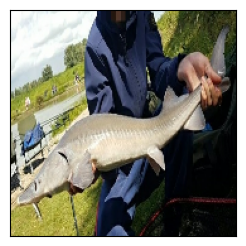

In [86]:
# testing using sample label - to try debug final evaluation
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_imgs[i].astype("uint8")) #images[i].numpy().astype("uint8"))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_names[sample_labels[i]])
plt.show()

## My model (based on TM358 EMA model)

### Data augmentation

In [ ]:
# Creating the normalisation layer
norm_layer = layers.Normalization(input_shape=(image_size))
norm_layer.adapt(train_dataset.map(lambda x, y: x))

In [ ]:
# Creating an augmented subset
data_augmentation = tf.keras.Sequential([
layers.RandomRotation(0.2),
#layers.RandomZoom(height_factor=0.1),
layers.RandomFlip(mode='horizontal')
])

aug_train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
num_parallel_calls=tf.data.AUTOTUNE)
aug_train_dataset = aug_train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

### Model creation

In [ ]:
# Define function to create model and compile
def build_model():
    model = Sequential([
        #norm_layer, # to normalise data - making training freeze
        Conv2D(filters=16, kernel_size=(3,3), padding='same',
        input_shape=image_size, activation='relu'),
        Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',#(learning_rate=0.005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
        )
    return model

In [ ]:
# Build the model using the build_model function
model=build_model()

In [ ]:
# Show a summary of the model
model.summary()

### Train the model

In [ ]:
# Train the model
#with tf.device("/device:GPU:0"):
hist=model.fit(
aug_train_dataset, 
validation_data=val_dataset, 
verbose=1,
epochs=5)

In [ ]:
# Plotting training loss and accuracy as well as validation loss and accuracy over the number of epochs
hist_dict = hist.history

# obtain the accuracy and loss of the training set and verification set in the returned
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend() # show legend 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
plt.figure()

plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

### Evaluating the model (based on code from TM358)

In [ ]:
model.evaluate(test_dataset, return_dict=True)

In [ ]:
test_predictions=model.predict(test_dataset)
test_predictions.shape

In [ ]:
predict_labels = np.argmax(test_predictions, axis=1)
predict_labels.shape

In [ ]:
actual_labels=np.array(list(test_dataset.unbatch().map(lambda x,y: y).as_numpy_iterator()))
#actual_labels=class_names
actual_labels=np.argmax(actual_labels, axis=0)
#actual_labels.shape
#actual_labels
print(actual_labels)

In [ ]:
#  actual_label = LABEL_TEXT[test_labels[i]]

In [ ]:
sample_imgs, sample_labels = test_dataset.as_numpy_iterator().next()
sample_imgs.shape, sample_labels.shape, sample_labels

In [ ]:
sample_predictions = model(sample_imgs)
# View the true and predicted labels of sample images
plt.figure(figsize=(15,15))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_imgs[i].astype("uint8"))
    #plt.imshow(sample_imgs[i])
    p_class = np.argmax(sample_predictions[i])
    a_class = np.argmax(sample_labels[i])#sample
    #plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",
    plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",# class_names[a_class]
    color=("green" if p_class == a_class else "red"))
    plt.axis("off")
plt.show()